# `trending` demo
This simple module helps you determine to what degree a time series is "trending." In fact, the module is so simple that you can just copy the code from trending.py into your project.

A series can be defined as "trending" if it has strong recent growth. My way of modeling this is by taking the geometric mean of growth rates, but weighting recent observations more heavily using a *reversed* geometric series of weights. That's it!

Mathematically, the steps are as follows:
1. Compute the growth rates between consecutive values in the series. So for a series $\mathbf{x}$, the growth series would be $\mathbf{g} = \{g_1, g_2, \ldots, g_{n-1}\} = \{\frac{x_2}{x_1}, \frac{x_3}{x_2}, \ldots, \frac{x_n}{x_{n-1}}\}$
where $n$ is the number of values in the series.
1. Compute weights as $\mathbf{w} = \{r^{n-2}, r^{n-3}, \ldots, r^{0}\}$ where $0 \le r \le 1$. (Note that the first exponent in the $\mathbf{w}$ series is $n-2$ because $\mathbf{w}$ ends exponentiation at zero and there are $n-1$ values in $\mathbf{g}$.)
1. Take the weighted geometric mean:
$$
{\bar  {g}}=\left(\prod _{{i=1}}^{n-1}g_{i}^{{w_{i}}}\right)^{{1/\sum _{{i=1}}^{n-1}w_{i}}}
$$

The value $r$ is the only parameter that needs to be chosen. The process for choosing it is described below, where we'll simulate a number of random walks and then see what the process deems to be the series that have the strongest recent growth given different values of $r$.

In [4]:
from math import sqrt
import random

import matplotlib.pyplot as plt

from trending import trending

%matplotlib inline

To start, let's generate `num_series` random walks, each with `n` observations.

Note that:
- Only positive values are allowed.
- Random walks start between $0$ and $2\sqrt{n}$ to simulate more realistic time series.

In [2]:
def random_walk(n):
    step_set = [-1, 0, 1]
    vals = [random.randint(0, int(2 * sqrt(n)))]
    for _ in range(1, n):
        val = vals[-1] + random.choice(step_set)
        val = max(0, val)
        vals.append(val)
    return vals


def generate_series(num_series, n):
    series = [random_walk(n) for _ in range(num_series)]
    return series


n = 1000
num_series = 1000
series = generate_series(num_series, n)

Next let's choose the `top_n` time series with the strongest recent growth.

First we'll need to choose an $r$ parameter. To do this, we'll use a function that *finds* $r$ in a way that answers the question, "Which value of $r$ will make it so that $x\%$ of my values fall within the last $m$ observations in my time series?" The code below sets $x\%$ constant at 50\% and varies $m$ to give a sense of how $r$ affects the recent growth calculation.

I'll also add a pseudo count to each value in each series, for two reasons:
1. It avoids divide-by-zero errors. (Otherwise, an increase from 0 to 1 would give an undefined growth number.)
1. It gives time series with low values a disproportionally lower recent growth value. (Otherwise, a time series of mostly 1's jumping up to 2's and 3's would be seen as having massive growth.)

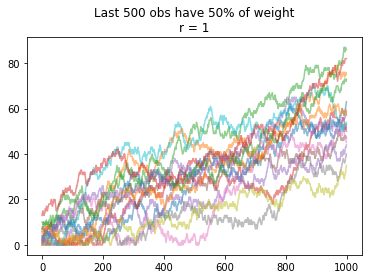

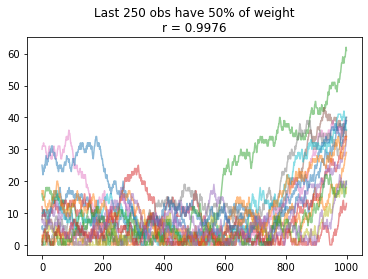

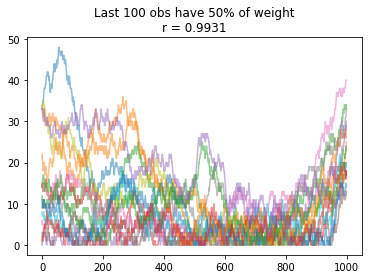

In [5]:
frac = 0.5  # percent of weight of first m obs relative to total weight
pseudo_count = 10  # added to each value in each series
top_n = 15  # number of series to choose

# Find r for various values of m.
p_list = list()
titles = list()  # for plots
m_list = [500, 250, 100]
for m in m_list:
    if m / n >= frac:
        p = 1
    else:
        p = trending.find_r(frac, m, n)
    p_list.append(p)

    title = f'Last {m} obs have 50% of weight\nr = {p:0.4g}'
    titles.append(title)

# Plot time series with highest recent growth given r.
for p, title in zip(p_list, titles):
    def _trend_func(a):
        a = [x + pseudo_count for x in a]
        return trending.recent_growth(a, p)
    series = sorted(series, key=_trend_func, reverse=True)
    for i in range(top_n):
        plt.plot(series[i], alpha=0.5)
    plt.title(title)
    plt.show()

We see that when $r = 1$, the series favors random walks that grow evenly over the entire series, starting low and ending high. This is because when $r = 1$, all observations in the series are given equal weight. In the next plot, where the last 250 observations have 50% of the weight, the series start to have more of a hockey-stick shape, favoring more recent growth. When the last 100 observations have 50% of the weight, this pattern becomes even more pronounced.